# Creating Customer Segments - Unsupervised Learning

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import skew
from scipy import stats

## Purpose

We will analyze a dataset containing data on various customers' annual spending amounts (reported in monetary units) of diverse product categories for internal structure

The goals of the project are :
- To find the best clusters of the dataset
- To find the characteristic of the the best clusters
- Provide the recommendation from the best clusters

## Import Dataset 

In [2]:
df = pd.read_csv('customers.csv')

In [3]:
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


Features
1. Fresh: annual spending (m.u.) on fresh products (Continuous);
2. Milk: annual spending (m.u.) on milk products (Continuous);
3. Grocery: annual spending (m.u.) on grocery products (Continuous);
4. Frozen: annual spending (m.u.) on frozen products (Continuous);
5. Detergents_Paper: annual spending (m.u.) on detergents and paper products (Continuous);
6. Delicatessen: annual spending (m.u.) on and delicatessen products (Continuous);
7. Channel: {Hotel/Restaurant/Cafe - 1, Retail - 2} (Nominal)
8. Region: {Lisbon - 1, Oporto - 2, or Other - 3} (Nominal)

## Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicatessen      440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


### Checking unique value

In [5]:
for col in df.columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("="*10)

Column: Channel
[2 1]
Column: Region
[3 1 2]
Column: Fresh
[ 12669   7057   6353  13265  22615   9413  12126   7579   5963   6006
   3366  13146  31714  21217  24653  10253   1020   5876  18601   7780
  17546   5567  31276  26373  22647  16165   9898  14276   4113  43088
  18815   2612  21632  29729   1502    688  29955  15168   4591  56159
  24025  19176  10850    630   9670   5181   3103  44466  11519   4967
   6269   3347  40721    491  27329   5264   4098   5417  13779   6137
   8590  35942   7823   9396   4760     85      9  19913   2446   8352
  16705  18291   4420  19899   8190  20398    717  12205  10766   1640
   7005    219  10362  20874  11867  16117  22925  43265   7864  24904
  11405  12754   9198  11314   5626      3     23    403    503   9658
  11594   1420   2932  56082  14100  15587   1454   8797   1531   1406
  11818  12579  19046  14438  18044  11134  11173   6990  20049   8258
  17160   4020  12212  11170  36050  76237  19219  21465    140  42312
   7149   2101  14

### Checking for duplicate values

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicatessen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


Findings :
- Mean > media means the dataset Skew Positive 
- The dataset has Outliers
- Fresh, Milk, and Grocery are the top three mean, indicate that Fresh, Milk, and Grocery have high demand
- The statistic description such as the products are quite dominant at Hotel/cafe/restaurant market

### Checking for duplicate values

In [8]:
df.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicatessen        0
dtype: int64

In [9]:
df["Channel"].replace({1:'Hospitality', 2:'Retail'}, inplace=True)    #Channel:{Hotel/Restaurant/Cafe - 1, Retail - 2}
df["Region"].replace({1:'Lisbon', 2:'Oporto', 3:'Other'}, inplace=True)  #Region:{Lisbon - 1, Oporto - 2, or Other - 3} (Nominal)

## Outliers checking and data standardization

In [10]:
cat=[]
num=[]
for i in df.columns:
  if df[i].dtype=='object':
    cat.append(i)
  else:
    num.append(i)
print('cat = ',cat)
print('num = ',num)

cat =  ['Channel', 'Region']
num =  ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']


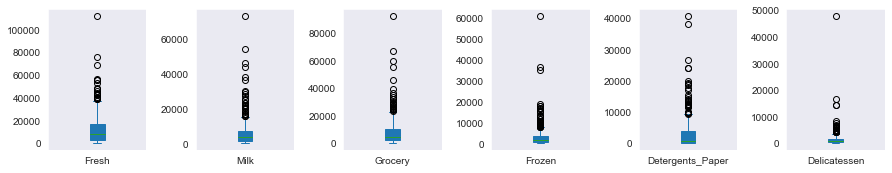

In [11]:
sns.set_style('dark')
df[num].plot(subplots=True, layout=(5,6), kind='box', figsize=(15,15), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

In [12]:
def dist_plot(df, cols):
  sns.set_style('dark')
  plt.figure(figsize=(19,19))
  for i, col in enumerate(cols):
    ax = plt.subplot(3,3, i+1)
    sns.kdeplot(df[col], ax=ax)
    plt.text(0.5,0.9,"skew= " + str(round(skew(df[col]),2)), bbox=dict(facecolor='yellow', alpha=0.5), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.xlabel(col)
  plt.show()

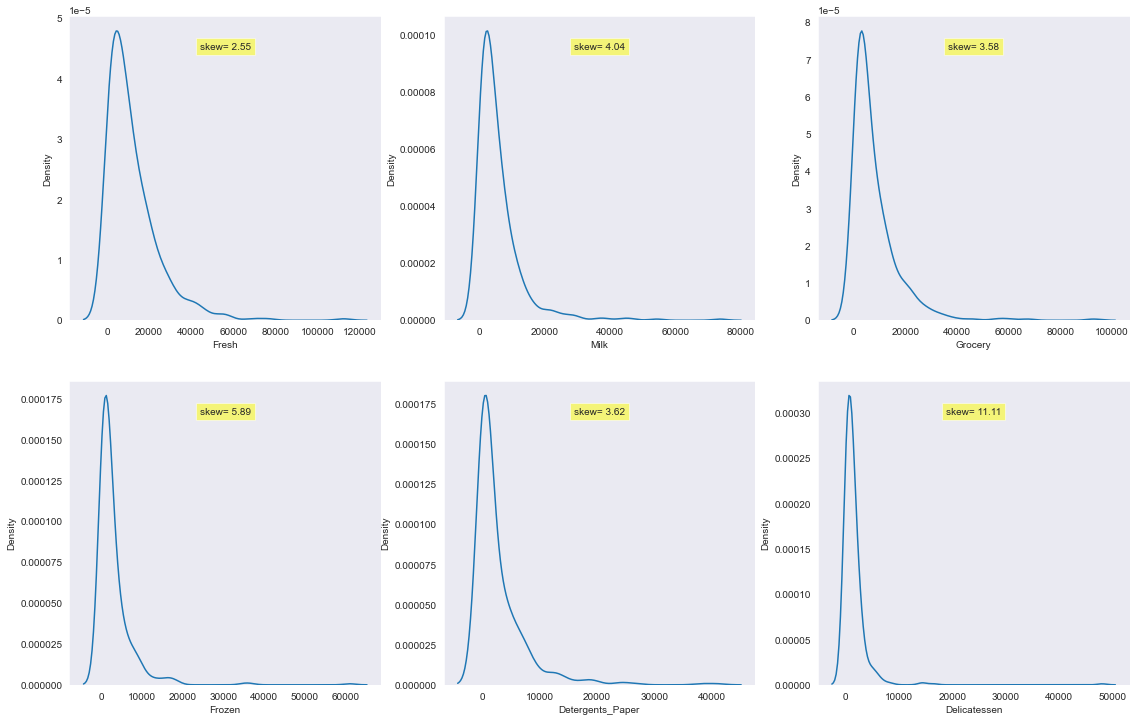

In [13]:
dist_plot(df, num)

In [14]:
def remove_outlier(col):
    sorted(col)
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR=Q3-Q1
    lower= Q1-(1.5 * IQR)
    upper= Q3+(1.5 * IQR)
    return lower, upper

for column in df.columns:
    if df[column].dtype != 'object': 
        lr,ur=remove_outlier(df[column])
        df[column]=np.where(df[column]>ur,ur,df[column])
        df[column]=np.where(df[column]<lr,lr,df[column])

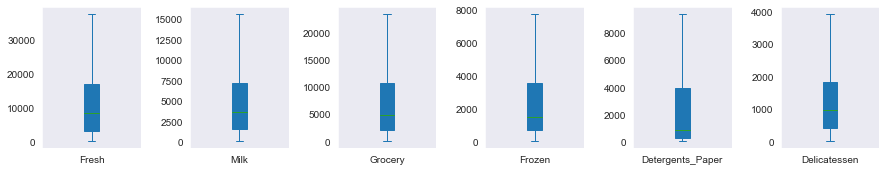

In [15]:
sns.set_style('dark')
df[num].plot(subplots=True, layout=(5,6), kind='box', figsize=(15,15), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

## Exploratory Data Analysis

In [16]:
df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.00000,440.000000,440.000000,440.000000
mean,11357.568182,5048.592045,7236.37500,2507.085795,2392.616477,1266.715341
std,10211.542235,4386.377073,6596.53308,2408.297738,2940.794090,1083.069792
min,3.000000,55.000000,3.00000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.00000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.50000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.75000,3554.250000,3922.000000,1820.250000
max,37642.750000,15676.125000,23409.87500,7772.250000,9419.875000,3938.250000


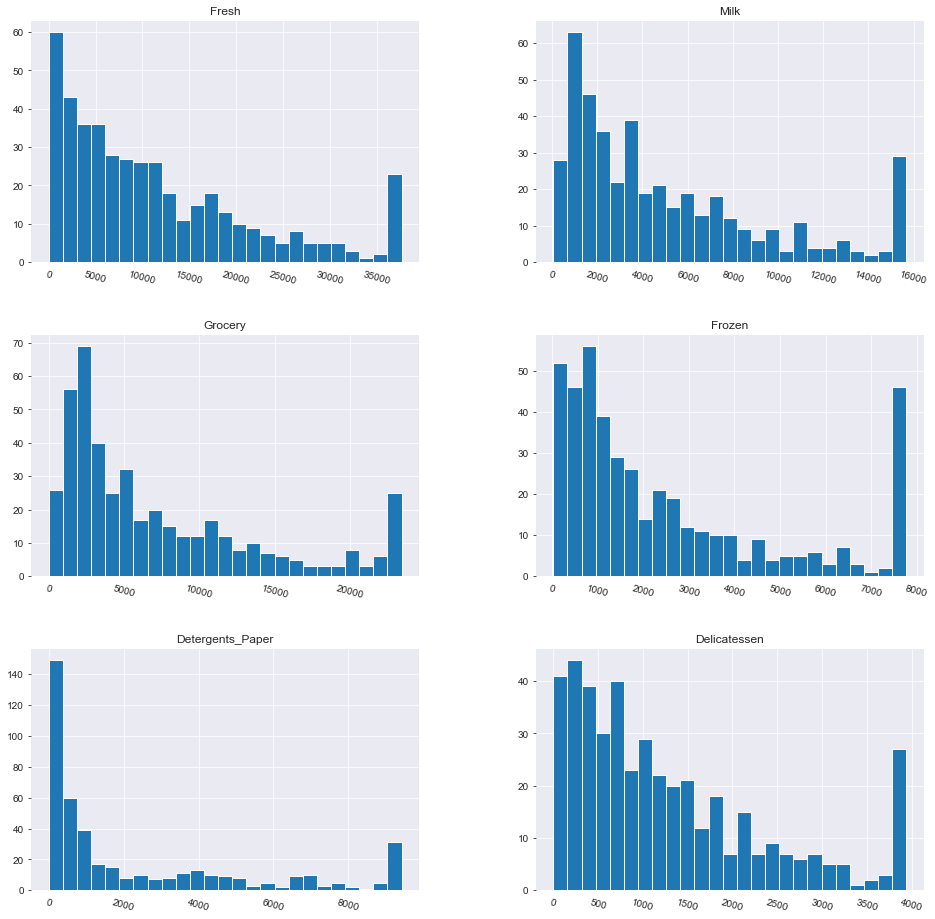

In [17]:
h = df.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

Findings :
- Most products, the higher the annual spending, the lower the number of customers
- Fresh, Milk, Grocery are the top 3 products of the dataset
- The visualization seems like the products are really good in Hospitality markets
- Detergents Paper is the lowest demand on the dataset
- Detergents Paper is usually sold on retail markets

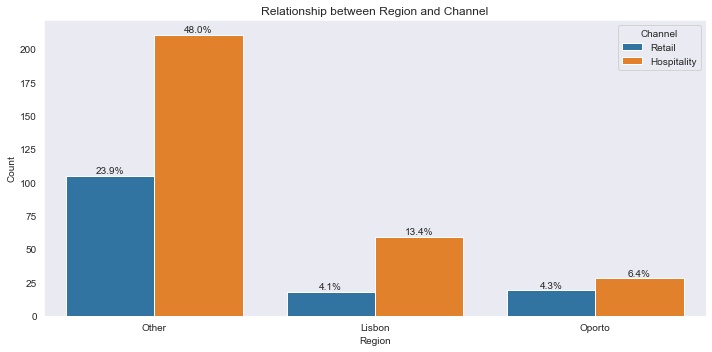

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x='Region', hue= 'Channel', data=df)
plt.ylabel('Count')
plt.title('Relationship between Region and Channel')
total_check = len(df)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total_check:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
- Hospitality is quite dominant in every region 
- Which mean that the demand of the product based on the region, show that Hospitality has more demand than retail
- Other and Lisbon have significant differences between Hospitality and retail
- The visualization seems like Other and lisbon are big city or tourist attraction
- The visualization seems like Oporto is small city that the people buy the necessities in retail merket

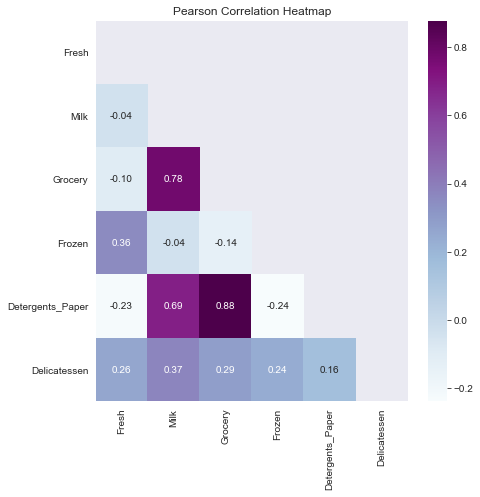

In [19]:
df_corr = df.corr()
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(df_corr,mask=mask, 
                 annot=True, annot_kws={'size':10}, fmt=".2f", cmap = "BuPu")
plt.title("Pearson Correlation Heatmap")
plt.show()

Findings:
- Detergents_Paper vs Grocery
- Milk vs Detergents_Paper
- Milk vs Grocery 

Detergents_Paper, Milk, and Grocery have strong correlation which indicate there are features that not imprortant between Detergents_Paper, Milk, and Grocery

## Data Preprocessing

### Scaling data to reduce skew

In [20]:
scaler = StandardScaler()
df_scaler = pd.DataFrame(scaler.fit_transform(df[num].astype('int64')), columns=num, index=df.index)
df_scaler.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0.128577,1.051592,0.049276,-0.953255,0.095817,0.065909
1,-0.421627,1.086741,0.353878,-0.309732,0.306554,0.470789
2,-0.490648,0.858046,0.067943,-0.042428,0.382474,2.469309
3,0.187009,-0.879310,-0.457636,1.620008,-0.641934,0.481882
4,1.103690,0.082489,-0.005817,0.585298,-0.209565,2.469309


In [21]:
df_final = pd.concat([df_scaler, df.drop(axis=1, columns=num)],axis=1)
df_final

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Channel,Region
0,0.128577,1.051592,0.049276,-0.953255,0.095817,0.065909,Retail,Other
1,-0.421627,1.086741,0.353878,-0.309732,0.306554,0.470789,Retail,Other
2,-0.490648,0.858046,0.067943,-0.042428,0.382474,2.469309,Retail,Other
3,0.187009,-0.879310,-0.457636,1.620008,-0.641934,0.481882,Hospitality,Other
4,1.103690,0.082489,-0.005817,0.585298,-0.209565,2.469309,Retail,Other
...,...,...,...,...,...,...,...,...
435,1.798603,1.598225,1.334161,2.188703,-0.752579,0.866426,Hospitality,Other
436,2.576948,-0.825674,-0.982305,0.832648,-0.782879,0.997689,Hospitality,Other
437,0.311129,2.382683,2.454527,-0.860551,2.392137,0.554908,Retail,Other
438,-0.104662,-0.700143,-0.759507,-0.610708,-0.757346,0.793400,Hospitality,Other


## Modeling

### Applying PCA

Principal component analysis (PCA) is a technique used for identification of a smaller number of uncorrelated variables known as principal components from a larger set of data. The technique is widely used to emphasize variation and capture strong patterns in a dataset.

In [22]:
pca = PCA(n_components=6)
X_red = pca.fit_transform(df_scaler)

pcaSummary = pd.DataFrame({'std_deviation': np.sqrt(pca.explained_variance_),
              'prop_of_variance' : pca.explained_variance_ratio_,
              'cum_prop_var': np.cumsum(pca.explained_variance_ratio_)})
pcaSummary_tps = pcaSummary.transpose()
pcaSummary_tps.columns = ['PC{}'.format(i) for i in range(1,len(pcaSummary_tps.columns) + 1)]
pcaSummary_tps

,PC1,PC2,PC3,PC4,PC5,PC6
std_deviation,1.656132,1.272979,0.804807,0.787958,0.529705,0.318179
prop_of_variance,0.456090,0.269466,0.107707,0.103244,0.046658,0.016835
cum_prop_var,0.456090,0.725556,0.833263,0.936507,0.983165,1.000000


2 Principal components:
PC1 + PC2 = 72.5% information based on the dataset that has applied PCA.

In [23]:
pcacomponents_df = pd.DataFrame(pca.components_.transpose(), columns=pcaSummary_tps.columns,
                                index=df_scaler.columns)
pcacomponents_df

,PC1,PC2,PC3,PC4,PC5,PC6
Fresh,-0.107597,0.590955,-0.614557,-0.506422,-0.036297,-0.061106
Milk,0.532870,0.134664,0.059085,-0.066975,0.815194,-0.159367
Grocery,0.573967,0.019924,0.016016,-0.191642,-0.247542,0.756244
Frozen,-0.124065,0.579882,0.768553,-0.220098,-0.093103,-0.023643
Detergents_Paper,0.554450,-0.123953,0.045579,-0.206968,-0.485392,-0.629843
Delicatessen,0.228532,0.529730,-0.160687,0.781694,-0.169089,-0.041260


### Dimensionality Reduction

Dimensionality Reduction is the transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data, ideally close to its intrinsic dimension.

In [24]:
pca = PCA(n_components=2)
pca.fit(df_scaler)
pcs = pca.transform(df_scaler)

X_std_pca = pd.DataFrame(data = pcs, columns = ['pc1', 'pc2'])
X_std_pca

,pc1,pc2
0,0.761264,-0.311162
1,1.143559,-0.063983
2,1.330660,1.063005
3,-1.198130,1.257235
4,0.297371,2.336670
...,...,...
435,0.933082,3.126143
436,-1.590427,2.500483
437,4.204901,0.052049
438,-0.960581,-0.011242


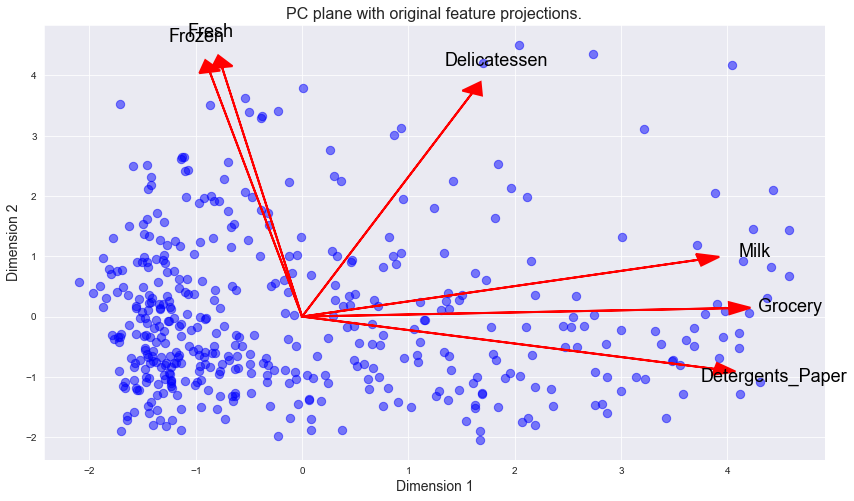

In [25]:
fig, ax = plt.subplots(figsize = (14,8))
# scatterplot of the reduced data    
ax.scatter(x=X_std_pca.loc[:, 'pc1'], y=X_std_pca.loc[:, 'pc2'],
facecolors='b', edgecolors='b', s=70, alpha=0.5)
feature_vectors = pca.components_.T

# we use scaling factors to make the arrows easier to see
arrow_size, text_pos = 7.0, 8.0,

# projections of the original features
for i, v in enumerate(feature_vectors):
    ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                head_width=0.2, head_length=0.2, linewidth=2, color='red')
    ax.text(v[0]*text_pos, v[1]*text_pos, df_scaler.columns[i], color='black', 
                ha='center', va='center', fontsize=18)
ax.grid(True)
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("PC plane with original feature projections.", fontsize=16);

Findings:
    
- The diversity of the graph shows that the diversity of the seven variables is relatively similar, because the vector lengths are almost the same
- Fresh vs Froze (Positive Correlation)
- Milk vs Grocery vs Detergents_Paper (Positive Correlation)
- Milk, Grocery, Detergents_Paper vs Fresh, Froze (Negative Correlation)
- Delicatessen vs Detergents_Paper (Close to 90 degrees)
- Delicatessen vs frozen (Close to 90 degrees)

### Elbow Method and silhouette coefficient

- The elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.


- Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified. The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In [26]:
kmeans_sse = []
kmeans_silhouette = []

for k in range(2,13):
    k_means = KMeans(n_clusters = k, init = 'k-means++', n_init = 15, max_iter = 100, 
                     random_state = 42).fit(df_scaler)
    kmeans_sse.append(k_means.inertia_)
    kmeans_silhouette.append(silhouette_score(df_scaler, k_means.labels_)) 

In [27]:
kmeans_silhouette

[0.36726613312228434,
 0.32149131646279444,
 0.3075803335110383,
 0.2805016620440639,
 0.2814175589573621,
 0.28918651746570484,
 0.28183467572877735,
 0.2615650708318331,
 0.25633677773907027,
 0.24404932485592445,
 0.21653208673314897]

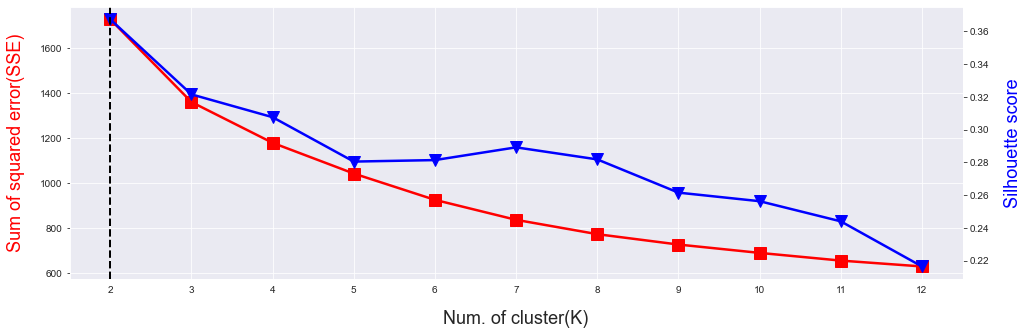

In [28]:
fig, ax1 = plt.subplots(figsize = (16,5))

ax1.plot(range(2, len(kmeans_sse) + 2), kmeans_sse, marker = 's', markersize = 12, 
         linewidth = 2.5, color = 'red')
ax1.set_xlabel("Num. of cluster(K)", fontsize = 18, labelpad = 15)
ax1.set_ylabel("Sum of squared error(SSE)", color = 'red', fontsize = 18, labelpad = 15)
ax1.grid(True)

ax2 = ax1.twinx()

ax2.plot(range(2, len(kmeans_silhouette) + 2), kmeans_silhouette, marker = 'v', markersize = 12, 
         linewidth = 2.5, color = 'blue')
ax2.set_ylabel("Silhouette score", color = 'blue', fontsize = 18, labelpad = 15)
ax2.grid(False)

ax2.axvline(x = 2, linestyle = '--', lw = 2, color = 'black')

plt.xticks(range(2, len(kmeans_silhouette) + 2))

plt.show()

The best silhouette is 2

### K-Means clustering 

In [29]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_scaler)

In [30]:
df['Clusters'] = kmeans.labels_

In [31]:
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Clusters
0,Retail,Other,12669.00,9656.0,7561.000,214.00,2674.000,1338.00,0
1,Retail,Other,7057.00,9810.0,9568.000,1762.00,3293.000,1776.00,0
2,Retail,Other,6353.00,8808.0,7684.000,2405.00,3516.000,3938.25,0
3,Hospitality,Other,13265.00,1196.0,4221.000,6404.00,507.000,1788.00,1
4,Retail,Other,22615.00,5410.0,7198.000,3915.00,1777.000,3938.25,1
...,...,...,...,...,...,...,...,...,...
435,Hospitality,Other,29703.00,12051.0,16027.000,7772.25,182.000,2204.00,0
436,Hospitality,Other,37642.75,1431.0,764.000,4510.00,93.000,2346.00,1
437,Retail,Other,14531.00,15488.0,23409.875,437.00,9419.875,1867.00,0
438,Hospitality,Other,10290.00,1981.0,2232.000,1038.00,168.000,2125.00,1


In [32]:
aggdata_k = df.iloc[:,:].groupby('Clusters').agg(['mean','median'])
aggdata_k['freq'] = df.Clusters.value_counts().sort_index()
aggdata_k

Fresh                  Milk               Grocery           \
                  mean  median          mean  median          mean   median   
Clusters                                                                      
0          8462.191057  4967.0  10328.003049  9933.0  15974.268293  14961.0   
1         12481.011041  9612.0   3000.113959  2280.0   3845.962145   2933.0   

               Frozen         Detergents_Paper         Delicatessen          \
                 mean  median             mean  median         mean  median   
Clusters                                                                      
0         1866.540650  1127.0      6290.839431  6707.0  1772.174797  1468.0   
1         2755.625394  1752.0       880.056782   415.0  1070.590694   786.0   

         freq  
               
Clusters       
0         123  
1         317

Findings :

- Clusters 0 has high annual spending on milk, grocery, Fresh, and detergents_Paper (retail goods)
- Clusters 1 has high annual spending on Fresh, grocery, froze, and Milk (Hospitality goods)

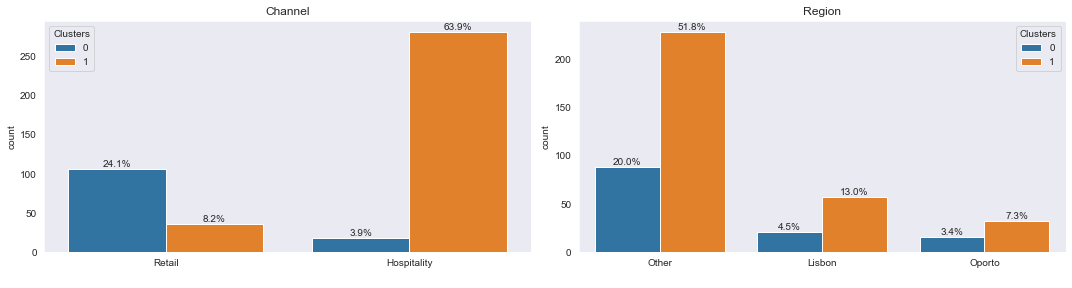

In [33]:
a = 1
plt.figure(figsize=[15,15])
df_n = df.loc[:,['Channel', 'Region', 'Clusters']]
for i in df_n.iloc[:,:-1].columns:
    plt.subplot(4,2,a)
    a+=1
    ax = sns.countplot(x=i, hue='Clusters', data=df_n)
    plt.title(i)
    plt.xlabel(' ')
    total = len(df_n)
    for p in ax.patches:
      percentage = f'{100 * p.get_height() / total:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings : 
- Clusters 0 is quite dominant on hospitality market and the highst customer on Other region
- Clusters 1 is quite dominant on hospitality market and region
- Other region such as big city or combined each region. My opinion on this visualitation is the company has a large market, but the headquarter is located in Lisbon or Oporto

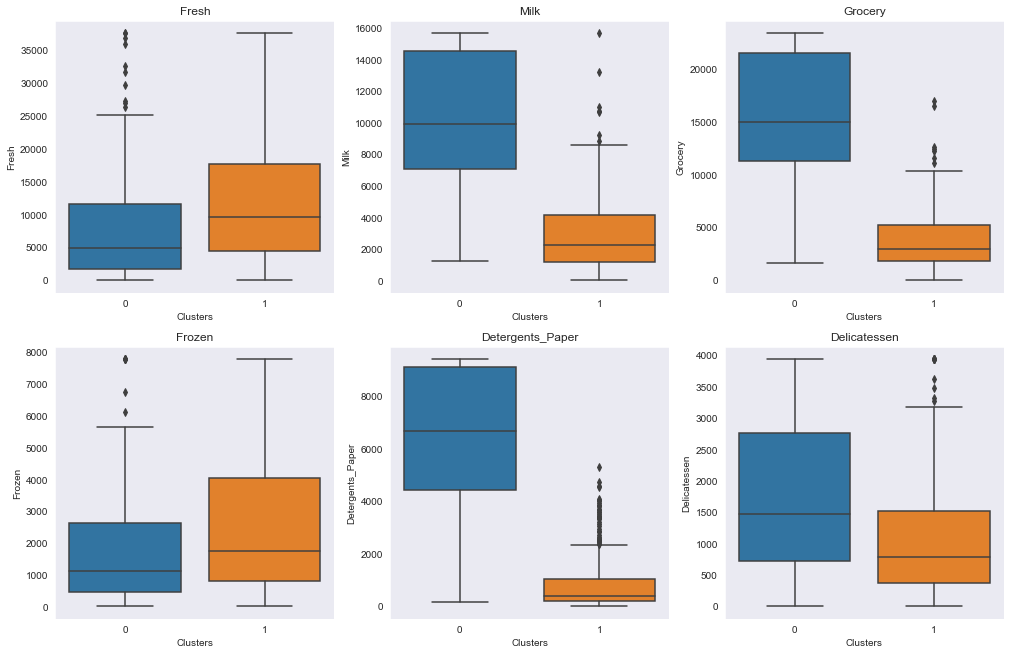

In [34]:
a = 1
df_n_check = df.loc[:,['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicatessen', 'Clusters']]
boxplot_cek = df_n_check.iloc[:,:-1]
fig, axes = plt.subplots(1,3,figsize=(17,17))
for i in boxplot_cek:
    plt.subplot(3,3,a)
    a+=1
    ax = sns.boxplot(y=i, x='Clusters', data=df_n_check)
    plt.title(i)

Findings:

- Such as the grouping of aggdata_k Clusters 0 has high annual spending on milk, grocery, Fresh, and detergents_Paper (retail goods) and Clusters 1 has high annual spending, which are Fresh, grocery, froze, and Milk (Hospitality goods)
- Clusters 0 has higher annual spending, which are milk, grocery, detergents_Paper, and Delicatessen than Clusters 1
- Clusters 1 has higher annual spending, which are Fresh and Frozen than Clusters 0

In [35]:
X_std_pca['Clusters'] = df['Clusters']

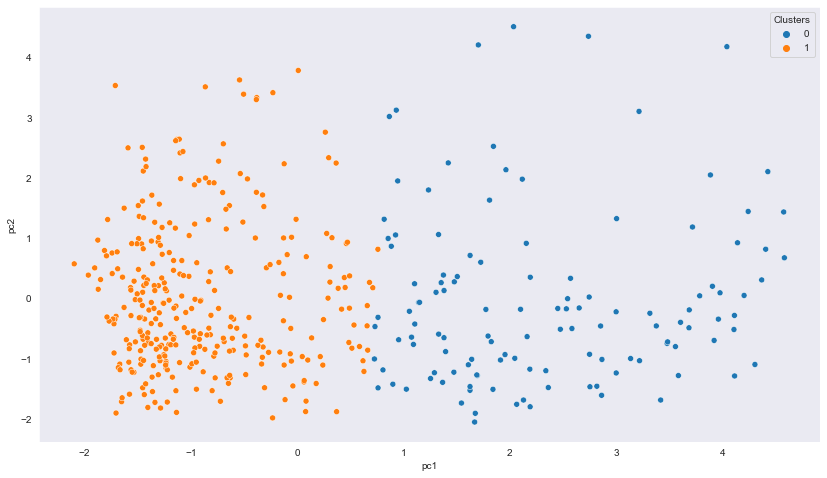

In [36]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes()
sns.scatterplot(x='pc1', y='pc2', hue='Clusters', data=X_std_pca)
plt.show()

Findings:

- Here is the plot of clusters distribution pattern
- The clusters are not quite gathering well
- But I think the clusters are well separated since we only have 2 clusters
- When you want to gather well the cluster, you can use another method such as T-SNE

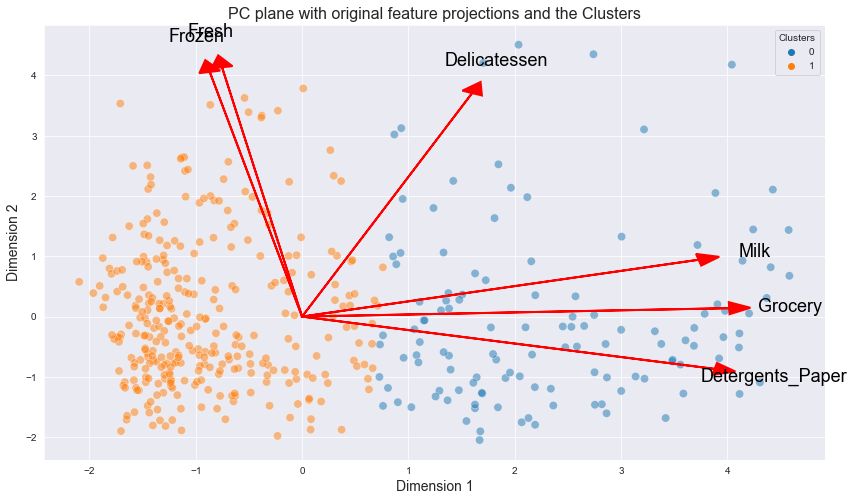

In [37]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes()
sns.scatterplot(x='pc1', y='pc2', hue='Clusters', data=X_std_pca,
facecolors='b', edgecolors='b', s=70, alpha=0.5)
feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
for i, v in enumerate(feature_vectors):
    ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                head_width=0.2, head_length=0.2, linewidth=2, color='red')
    ax.text(v[0]*text_pos, v[1]*text_pos, df_scaler.columns[i], color='black', 
                ha='center', va='center', fontsize=18)
ax.grid(True)
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("PC plane with original feature projections and the Clusters", fontsize=16);
plt.show()

Findings :

- Such as the analysis that we have done it. Clusters 1 has higher annual spending on Fresh and Frozen than Clusters 0 (Hospitality) and Clusters 1 has higher annual spending on Fresh and Frozen than Clusters 0 (Retail)
- Clusters 1 has more annual spending than Clusters 0

## Conclusion

- The best clusters of the dataset are 2 Clusters
- The characteristic of the best Clusters:
    - Clusters 0 has high annual spending on milk, grocery, Fresh, and detergents_Paper (retail goods)
    - Clusters 1 has higher annual spending on Fresh and Frozen than Clusters 0

## Recommendation

- From the characteristics of the clusters, we are able to stock products according to the needs of each cluster
- We can create warehouses with standards that match with the products based on clusters'caracteristics, near the clusters area to reduce operational costs
- We are  table do the marketing program based on the characteristics of the clusters